In [9]:
import classy as Class
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from astropy.cosmology import Planck15 as cosmo
from IPython.display import display, clear_output

######################################################
#  Setting fiducial parameters
######################################################

ln10e10As = 3.047
As = np.exp(ln10e10As)/(10**10)

standard_params = {
    "omega_b": 0.02242,
    "omega_cdm": 0.11933,
    "n_s": 0.9665,
    "tau_reio": 0.0561,
    "sigma8": 0.8102,
    "H0": 67.66
    #"A_s": As
}
######################################################
#  Setting up plots
######################################################

%config InlineBackend.figure_format = 'retina'
font = {'size'   : 16, 'family':'STIXGeneral'}
axislabelfontsize='large'
matplotlib.rc('font', **font)
matplotlib.mathtext.rcParams['legend.fontsize']='medium'
plt.rcParams["figure.figsize"] = [8.0,6.0]

######################################################
#  Finding where pivot points will be, as well as 
#  the indices of the pivots closest to what we want
######################################################

N = 1 #Number of basis functions
zmin_pert = 500 #min and max redshift of perturbations
zmax_pert = 1700

ll_max = 2500

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx, array[idx]

z_of_pert = np.array([900, 1100, 1300]) # redshifts we will introduce perturbations at
#z_of_pert = np.array([900, 1100]) # redshifts we will introduce perturbations at
linear_sampling = 0.5*20000  #number of timesteps during recombination


common_settings = {'output' : 'tCl,pCl,lCl',
                   # LambdaCDM parameters
                   'H0':standard_params["H0"],
                   'omega_b':standard_params["omega_b"],
                   'omega_cdm':standard_params["omega_cdm"],
                   #'A_s':standard_params["A_s"]
                   'sigma8': standard_params["sigma8"],
                   'n_s':standard_params["n_s"],
                   'tau_reio': standard_params["tau_reio"],
                   'thermodynamics_verbose': 0,
                   'input_verbose': 0,
                   'lensing': 'yes',
                   #'recombination': 'RECFAST',
                   'perturb_xe': 'yes',
                   'xe_pert_num': N,
                   'zmin_pert': zmin_pert,
                   'zmax_pert': zmax_pert,
                   'thermo_Nz_lin': linear_sampling,
                   #'use_spline_xe_pert': 'yes'
                   }  
 

M = Class.Class()
M.set(common_settings)

#amp = (3./2)*.01
#amplitudes = np.linspace(amp-.1, amp+.1, 21)
amplitudes = np.linspace(-.1, .1, 5)
middle = int((amplitudes.shape[0]-1)/2)

#dz = 10.58
dz = 13

actual_zi = []
responses = []
perts = []

ll = np.zeros(ll_max)

run_count = 0
run_total = z_of_pert.shape[0]*amplitudes.shape[0]

print("{0} of {1} runs completed\r".format(run_count, run_total))

for zi in z_of_pert:
    
    actual_zi.append(zi)
    array_of_cls = []
    
    width=dz/2.355
    
    #M.set({'xe_single_width': dz})
    M.set({'xe_single_width': width})

    M.set({'xe_single_zi': zi})

    for qi in amplitudes:
    #Setting up string of perturbation amplitudes
        amp_str = "{}".format(qi)
        M.set({'xe_pert_amps': amp_str}) #sets perturbation
        M.compute() ##Run CLASS

        cls = M.lensed_cl(ll_max)
        ll = cls['ell'][2:]
        array_of_cls.append(cls['tt'][2:])
        if(qi==amplitudes[-1]):
            perts.append((M.get_thermodynamics()['z'], M.get_thermodynamics()['xe_pert']))
        run_count+=1
        clear_output(wait=True)
        print("{0} of {1} runs completed\r".format(run_count, run_total))

    
    array_of_cls = np.stack(array_of_cls)
    fid = array_of_cls[middle]
    derivs = np.gradient(array_of_cls, amplitudes[1]-amplitudes[0], axis=0, edge_order=2)
    response = derivs[middle]/fid
    responses.append(response)

15 of 15 runs completed


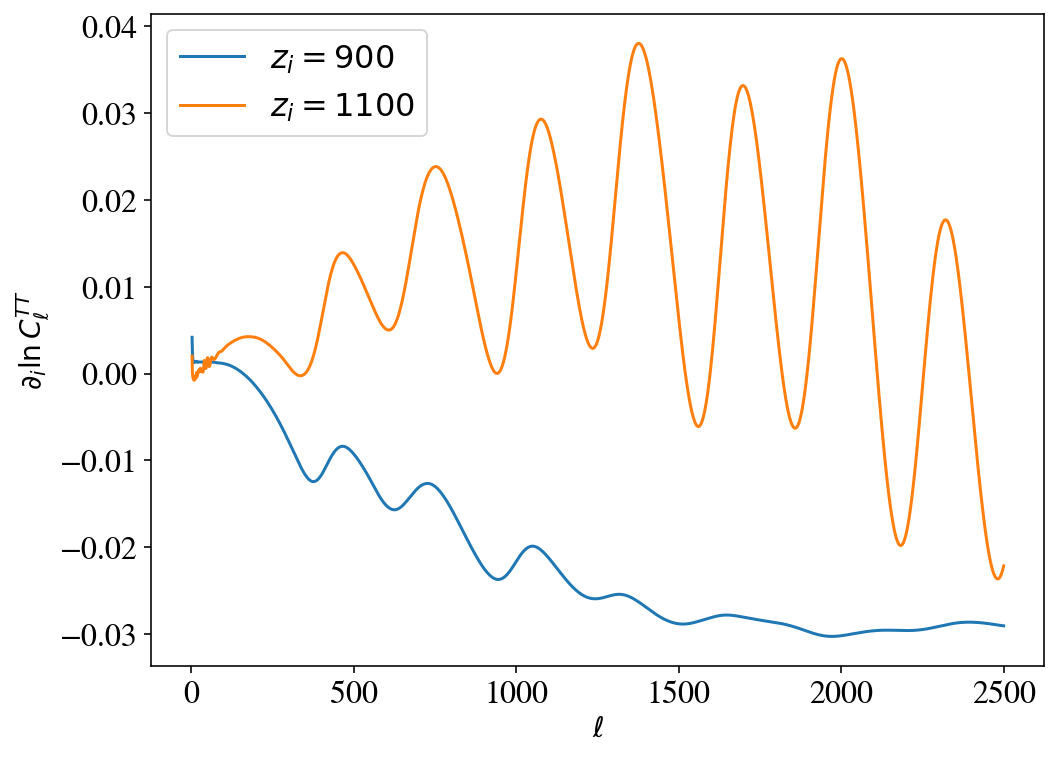

In [10]:
fig, ax = plt.subplots()

ax.plot(ll, responses[0], label="$z_i = {}$".format(actual_zi[0]))
ax.plot(ll, responses[1], label="$z_i = {}$".format(actual_zi[1]))
#ax.plot(ll, responses[2], label="$z_i = {}$".format(actual_zi[2]))
ax.set_xlabel("$\ell$", fontsize=14)
ax.set_ylabel("$\partial_i \ln C_{\ell}^{TT}$", fontsize=14)

plt.legend()

#plt.savefig("../results/CMBresponse.pdf",dpi=300)

#plt.show()

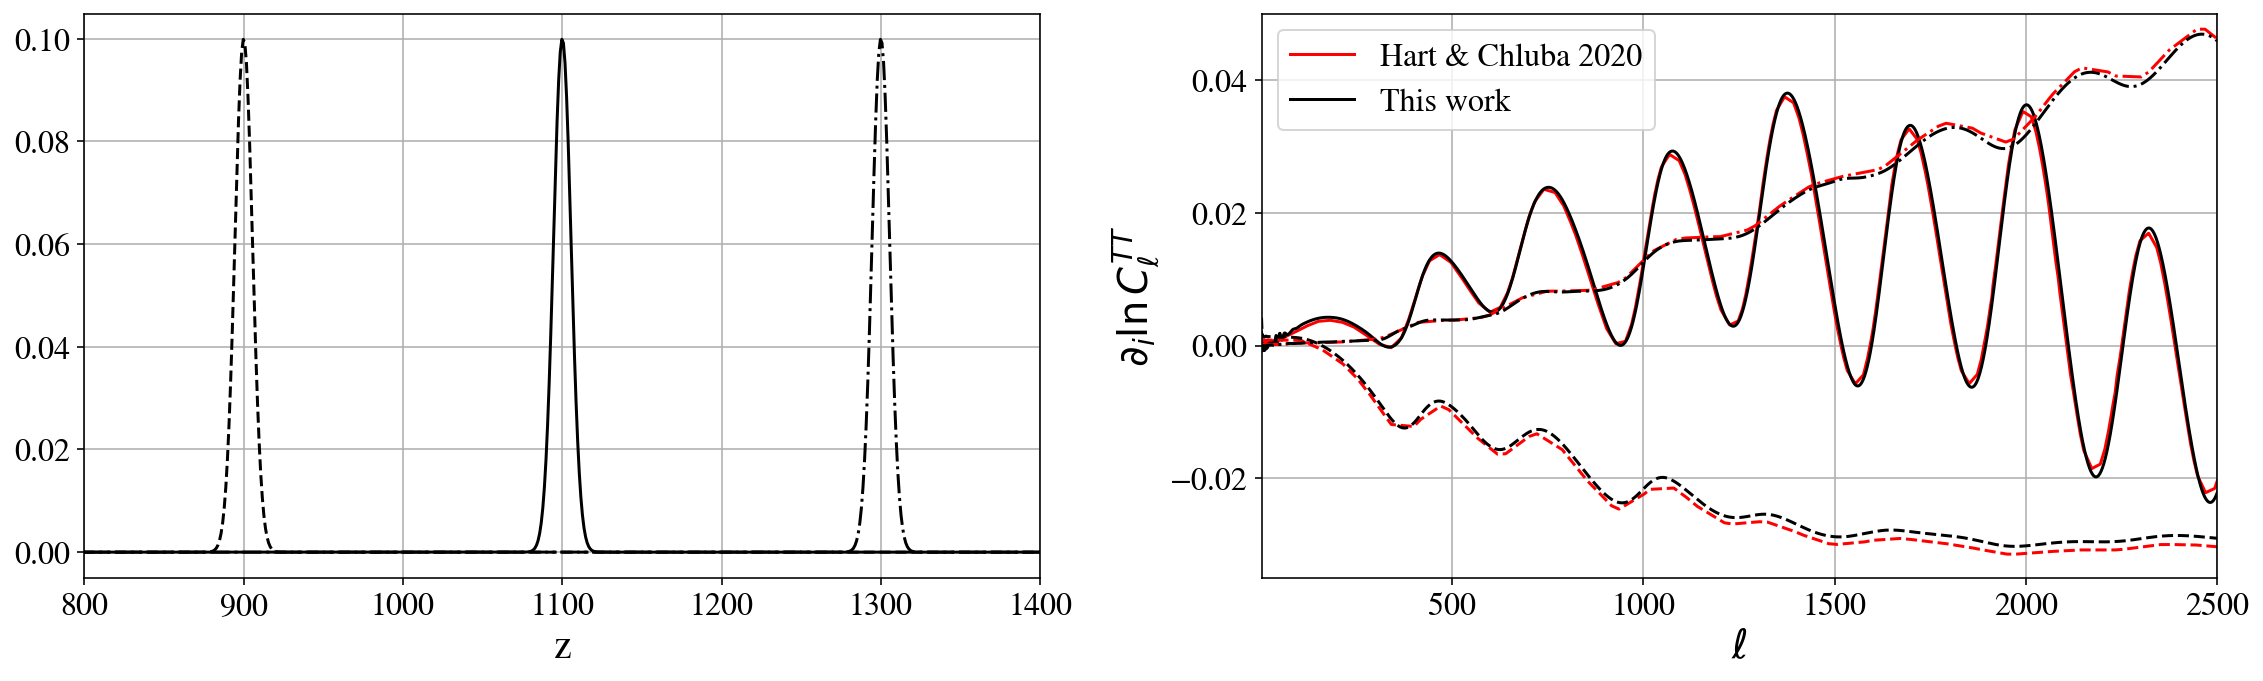

In [39]:
hc_z1100 = np.loadtxt("/Users/gabe/projects/recombination/data/csv/z1100.csv")
hc_z900 = np.loadtxt("/Users/gabe/projects/recombination/data/csv/z900.csv")
hc_z1300 = np.loadtxt("/Users/gabe/projects/recombination/data/csv/z1300.csv")

#hc_z1100 = np.loadtxt("farhang_black.csv")

fsize=20

#print(hc_z1100[:, 0])

fig, ax = plt.subplots(1, 2, figsize=(16, 5))


#grid = plt.GridSpec(6, 1, hspace=1)
#plt.figure(figsize=(10,12))
#ax = [plt.subplot(grid[:2, 0]), plt.subplot(grid[2:, 0])]


ax[1].plot(ll, np.interp(ll, hc_z1100[:,0], hc_z1100[:, 1]), label="Hart & Chluba 2020", color="red")
ax[1].plot(ll, responses[1], label="This work", color='black')
#ax[0].scatter(hc_z1100[:,0], hc_z1100[:, 1], label="$z_i = {}$, paper reference".format(1100), s=5, color="red")


ax[1].plot(ll, np.interp(ll, hc_z900[:,0], hc_z900[:, 1]),  color="red", linestyle='dashed')
ax[1].plot(ll, responses[0],  color='black', linestyle='dashed')
#ax[0].scatter(hc_z900[:,0], hc_z900[:, 1], label="$z_i = {}$, paper reference".format(1100), s=5, color="red")


ax[1].plot(ll, np.interp(ll, hc_z1300[:,0], hc_z1300[:, 1]), color="red", linestyle='dashdot')
ax[1].plot(ll, responses[2],  color='black', linestyle='dashdot')
#ax[0].scatter(hc_z1300[:,0], hc_z1300[:, 1], label="$z_i = {}$, paper reference".format(1100), s=5, color="red")


ax[1].set_xlabel("$\ell$", fontsize=fsize)
ax[1].set_ylabel("$\partial_i \ln C_{\ell}^{TT}$", fontsize=fsize)
ax[1].set_xlim([2, 2500])
ax[1].set_ylim([-0.035, 0.05])
#ax[0].set_xscale('log')
ax[1].legend(loc="upper left")
ax[1].grid(True)

ax[0].plot(perts[1][0], perts[1][1], color="black", label="$z_i = 1100$")
ax[0].plot(perts[0][0], perts[0][1], color="black", linestyle="dashed", label="$z_i = 900$")
ax[0].plot(perts[2][0], perts[2][1], color="black", linestyle="dashdot", label="$z_i = 1300$")
ax[0].set_xlabel("z", fontsize=fsize)
ax[0].set_xlim([800, 1400])

ax[0].grid(True)
#ax[0].legend()

#plt.legend()
#plt.savefig("../results/CMBresponse_vertical.png",dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()

In [11]:
width=dz/2.355
M.set({'xe_single_width': dz})
M.set({'xe_single_width': width})
M.set({'xe_single_zi': zi})

out_cls=[]
ll = np.zeros(ll_max)

run_count = 0
run_total = amplitudes.shape[0]

for qi in amplitudes:
    #Setting up string of perturbation amplitudes
        amp_str = "{}".format(qi)
        M.set({'xe_pert_amps': amp_str}) #sets perturbation
        M.compute() ##Run CLASS

        cls = M.lensed_cl(ll_max)
        ll = cls['ell'][2:]
        out_cls.append(cls['tt'][2:])
        
        run_count+=1
        clear_output(wait=True)
        print("{0} of {1} runs completed\r".format(run_count, run_total))

out_cls = np.array(out_cls)

5 of 5 runs completed


998 1000
1298 1300
1998 2000


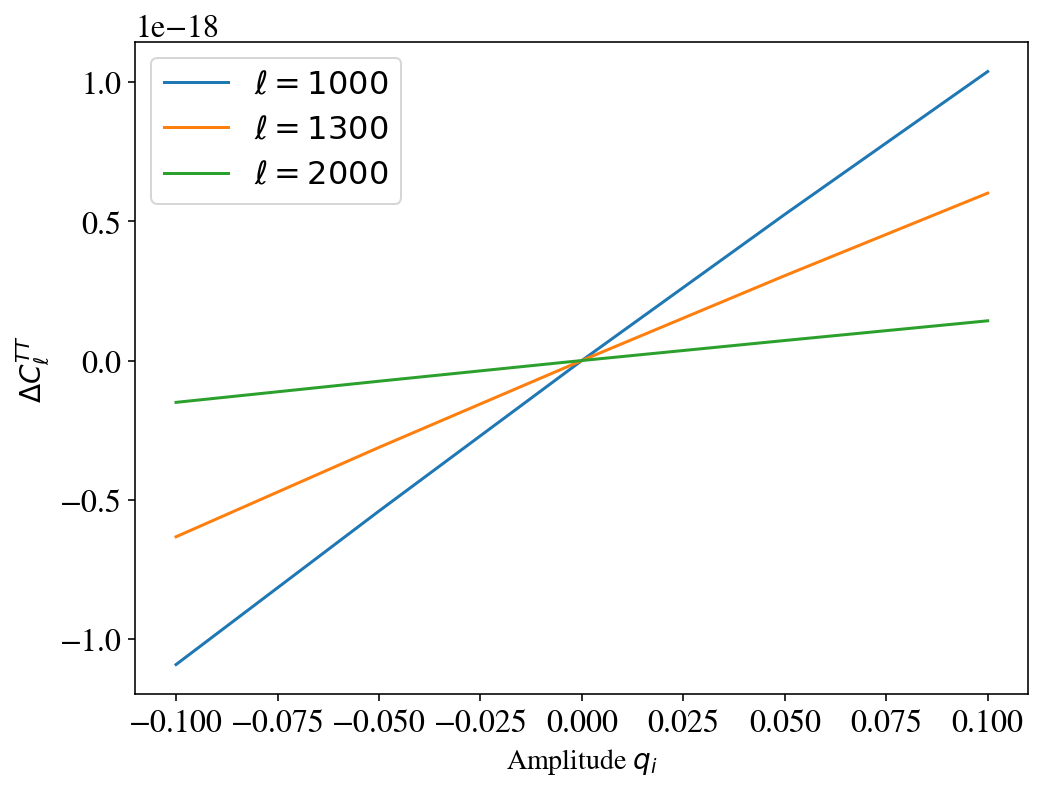

In [12]:
fig,ax = plt.subplots()

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx, array[idx]


ll_samples = [1000, 1300, 2000]

for ell in ll_samples:
    differences = []
    ll_idx, ll_val= find_nearest(ll, ell)
    print("{0} {1}".format(ll_idx, ll_val))
    for ps in out_cls:
        differences.append(ps[ll_idx] - out_cls[middle][ll_idx])
    ax.plot(amplitudes, differences, label="$\ell = {}$".format(ell))

ax.set_xlabel("Amplitude $q_i$", fontsize=14)
ax.set_ylabel("$\Delta C_{\ell}^{TT}$", fontsize=14)
plt.legend()
plt.show()